# Energy-shaping control

In this notebook we will develop a "swing-up and balance" controller for the Qube Servo rotary pendulum.  We will use a simple heuristic energy-shaping controller for the swing-up and then switch to a PID balancing controller when the pendulum is near the top.

In [7]:
import sys, os

import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt

import control

import collimator
from collimator import library, models
from collimator.library.quanser import animate_qube

from controllers import *

# Set to your ffmpeg path
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

HOME = os.path.expanduser("~")
sys.path.append(f"{HOME}/Quanser/libraries/python")

# Connect to physical hardware or QLabs simulation?
HARDWARE = False
version = 3 if HARDWARE else 2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


"Energy-shaping" is a classic nonlinear control strategy for relatively simple underactuated mechanical systems like the inverted pendulum, cart-pole, and double pendulum.  It is perhaps most easily understood in terms of the undamped pendulum, for which the equations of motion are

$$
m L^2 \ddot{\theta} + m g L \sin \theta = u,
$$

where $\theta$ is the deflection angle of the pendulum with $\theta=0$ in the down position and $u$ the external torque.  The total energy (kinetic + potential) of the pendulum is

$$
E(\theta, \dot{\theta}) = \frac{1}{2} m L^2 \dot{\theta}^2 - m g L \cos \theta
$$

Trajectories of the pendulum which have less energy than some critical value $E_0$ will not reach the vertical position.  We can compute the critical energy value by setting $\theta = \pi$, so that $E_0 = E(\theta, \dot{\theta}) = m g L$.  In principle, if the pendulum had _exactly_ this much energy then it would swing up to a vertical position.

The idea of energy-shaping control is to apply a sort of proportional feedback control to the _energy_ of the system in order to drive it to this critical value.  The time derivative of the energy can be computed as

$$
\dot{E} = u \dot{\theta},
$$

so choosing a feedback control law $u = -k \dot{\theta} \Delta E$ with $\Delta E = E(\theta, \dot{\theta}) - E_0$, we have that

$$
\dot{E} = \Delta \dot{E} = - k \dot{\theta} \Delta E,
$$

which tends to drive the energy of the system towards the critical value, i.e. $\Delta E \rightarrow 0$.

Let's do a quick simulation of the pendulum to see this controller in action.

collimator:INFO max_major_steps=200 by default since no discrete period in system
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=200, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


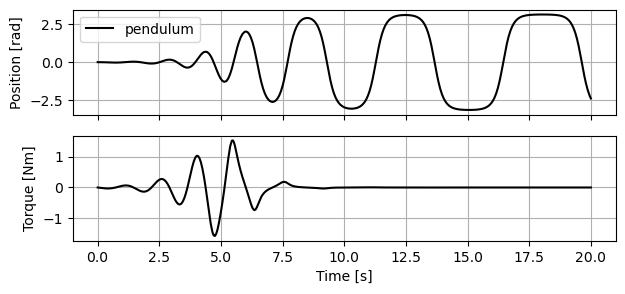

In [2]:
class PendulumEnergyShaping(library.FeedthroughBlock):
    def __init__(self, k, m, g, L, name="controller"):
        E0 = m * g * L

        def control(x):
            E = 0.5 * m * (L * x[1])**2 - m * g * L * jnp.cos(x[0])
            return -k * (E - E0) * x[1]

        super().__init__(control, name=name)


builder = collimator.DiagramBuilder()
m = 1.0
L = 0.5
g = 9.81
plant = models.Pendulum(
    m=m,
    L=L,
    g=g,
    x0=[1e-2, 0.0],
    full_state_output=True,
    input_port=True,
)
controller = PendulumEnergyShaping(k=0.05, m=m, g=g, L=L)
builder.add(plant, controller)
builder.connect(plant.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], plant.input_ports[0])

system = builder.build()
context = system.create_context()

recorded_signals = {
    "x": plant.output_ports[0],
    "u": controller.output_ports[0],
}

tf = 20.0
results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["x"][:, 0], c='k', label="pendulum")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="torque")
ax[1].set_ylabel("Torque [Nm]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

The pendulum is quickly driven close to the critical energy, but note that this controller is not stabilizing - the pendulum will stay close to vertical for a couple of seconds and then falls around to the other side.  We won't get into the analysis of nonlinear controllers here, but this motivates the need to switch to a different control strategy near the equilibrium point to ensure stability.

### Swing-up control for the rotary pendulum

The dynamics of the rotary pendulum are somewhat more complicated than the simple planar pendulum, but it is still possible to derive an energy-shaping control strategy for this system using feedback linearization combined with a similar approach to the planar pendulum.  However, this control strategy is robust enough that we can actually use a much simpler control law that will work for swing-up control.  This will get us "close enough" and then we will rely on the stabilization controller to take over from there.

The main observation is that we want to drive the potential energy to its value at equilibrium.  Ideally this would be accompanied by the kinetic energy going to zero, but this is the term we will neglect.  The pure potential-energy based control law is

$$
u = -k \dot{\alpha} (1 - \cos \alpha).
$$

This is the pendulum control law with the kinetic energy and all the constant parameters ignored.  It is also the negative of the pendulum law, since in the case of the rotary pendulum the motion of the rotor arm applies a torque in the opposite direction to the pendulum arm compared to the case of the planar pendulum.

Again, this is a very rough heuristic for a control law, but we will see that it is sufficient to add energy to the system with minimal torque inputs.  Since the time derivative of the pendulum angle is not measured directly, we will use the `DerivativeDiscrete` block with a bilinear filter to estimate it.

### Balancing control

PID control is a simple and effective stabilization controller; in this case we also do not need the integral term because the "set point" is an equilibrium point of the system, so we don't expect any steady-state bias.  We would like the balancing controller to drive both the rotor and pendulum angles to zero so that the rotor arm doesn't tend to drift.  This will require feedback control of both the rotor arm $\theta$ and the pendulum arm $\alpha$, a dual-PID controller.

The full feedback control law for the balancing controller is

$$
u = -(k_p^\theta \theta + k_p^\alpha (\alpha - \pi) + k_d^\theta \dot{\theta} + k_d^\alpha \dot{\alpha}).
$$

We have four gains to determine which can be challenging, especially for an unstable system.  However, note that the structure of this controller is identical to the LQR feedback law $u = -Kx$ given the full state $x = \begin{bmatrix} \theta & \alpha & \dot{\theta} & \dot{\alpha} \end{bmatrix}^T$.  As a result, we can use standard LQR design tools to determine the gains easily.

In [3]:
# Linearize the system and discretize in time
x_eq = np.array([0.0, np.pi, 0.0, 0.0])  # "Up" position
u_eq = np.array([0.0])
dt = 0.001  # 1 kHz sampling rate

plant = library.QubeServoModel(full_state_output=False, name="qube")
plant.input_ports[0].fix_value(u_eq)
context = plant.create_context()

base_context = context.with_continuous_state(x_eq)

# Linearize and discretize in time
lin_sys = library.linearize(plant, base_context).sample(dt)

# Design a state feedback controller
n = 4
m = 1
Q = np.eye(n)  # State cost weighting matrix
R = 1e1 * np.eye(m)  # Input cost weighting matrix
K, _, _ = control.dlqr(lin_sys.A, lin_sys.B, Q, R)
K

array([[ -0.30963582, -17.48798428,  -0.51359549,  -1.35003656]])

These gains are the negative of what the PID block will expect, so we can construct the PID gains as follows:

In [4]:
rotor_gains = (-K[0, 0], 0.0, -K[0, 2])  # PD control on theta and theta_dot
pendulum_gains = (-K[0, 1], 0.0, -K[0, 3])  # PD control on alpha and alpha_dot

These gains will be used to initialize two discrete-time PID controller blocks, one each for the rotor arm position and pendulum arm position.  In addition, we will define some switching logic to transition from the energy-shaping swing-up controller to the PID balancing controller.  The subdiagrams for each controller and the switching logic can be found in `controllers.py`.  We will also start the system with a discrete pulse to jump-start the system with a little kinetic energy.

In [5]:
def make_diagram(
    plant,
    dt,
    rotor_gains,
    pendulum_gains,
    pulse_amplitude=1.0,
    kE=0.01,
    name="root",
):
    y_eq = np.array([0.0, np.pi])

    builder = collimator.DiagramBuilder()

    swingup_controller = make_energy_shaping(dt, kE=kE)
    pid_controller = make_pid(dt, rotor_gains, pendulum_gains)

    controller = make_switched_controller(swingup_controller, pid_controller, y_eq)

    # Add initial impulse to start the swing-up controller
    pulse = make_pulse(amplitude=pulse_amplitude, start_time=2.0, width=0.1)
    adder = library.Adder(2, name="adder")

    builder.add(controller, plant, pulse, adder)
    builder.connect(pulse.output_ports[0], adder.input_ports[0])
    builder.connect(controller.output_ports[0], adder.input_ports[1])
    builder.connect(adder.output_ports[0], plant.input_ports[0])
    builder.connect(plant.output_ports[0], controller.input_ports[0])

    return builder.build(name=name)

First let's run this hybrid controller in a simulation with the Qube model:

collimator:INFO max_major_steps=19998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=19998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 4 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


|-- root
    |-- controller
        |-- EnergyShaping
            |-- y(id=8)
            |-- cos_alpha(id=9)
            |-- offset(id=10)
            |-- energy(id=11)
            |-- alpha_dot(id=12)
            |-- product(id=13)
            |-- gain(id=14)
            |-- u(id=15)
        |-- DualPID
            |-- y(id=17)
            |-- y_offset(id=18)
            |-- pid_alpha(id=19)
            |-- pid_theta(id=20)
            |-- voltage(id=21)
            |-- u(id=22)
        |-- y(id=24)
        |-- y_centered(id=25)
        |-- y_offset(id=26)
        |-- threshold(id=27)
        |-- abs_alpha(id=28)
        |-- demux(id=29)
        |-- near_upright(id=30)
        |-- switch(id=31)
        |-- voltage(id=32)
    |-- Qube(id=7)
    |-- Pulse
        |-- step1(id=34)
        |-- step2(id=35)
        |-- adder(id=36)
    |-- adder(id=38)


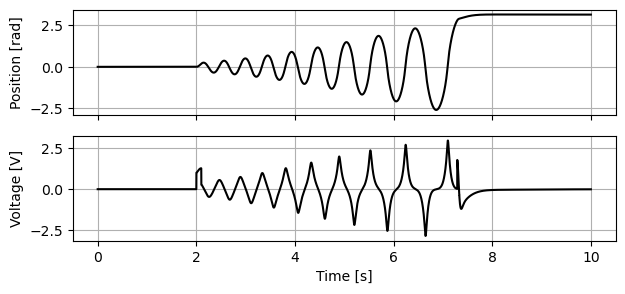

In [6]:
tf = 10.0
x0 = [0.0, 0.0, 0.0, 0.0]
plant = library.QubeServoModel(x0=x0, name="Qube", full_state_output=False)
system = make_diagram(plant, dt, rotor_gains, pendulum_gains, kE=0.05)
system.pprint()
context = system.create_context()

recorded_signals = {
    "y": plant.output_ports[0],
    "u": plant.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].set_ylabel("Position [rad]")
# ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="voltage")
ax[1].set_ylabel("Voltage [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()

In [25]:
# Simple matplotlib animation
t, x = results.time, results.outputs["y"]

# Interpolate for plotting on uniform interval
t_plt = np.linspace(t[0], t[-1], 500)
x_plt = np.zeros((len(t_plt), 4))
for i in range(2):
    x_plt[:, i] = np.interp(t_plt, t, x[:, i])

animate_qube(t_plt, x_plt, context[plant.system_id].parameters)

Finally we can run the same controller but swap out the analytic model for the hardware interface (or simulated hardware, if you are connecting to QLabs).

collimator:INFO max_major_steps=19998 based on smallest discrete period=0.001
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=19998, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 4 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Initialized Qube
Restoring sigint handler


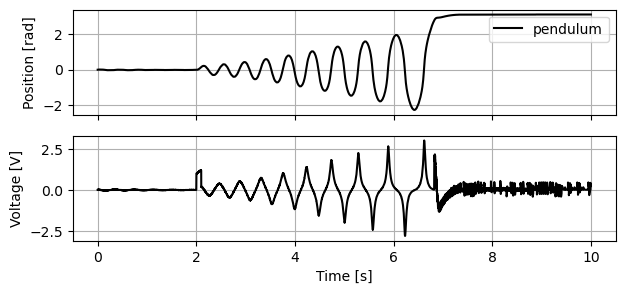

In [10]:
tf = 10.0
plant_hw = library.QuanserHAL(dt=dt, hardware=HARDWARE, version=version, name="Qube")

system = make_diagram(
    plant_hw,
    dt,
    rotor_gains=rotor_gains,
    pendulum_gains=pendulum_gains,
    kE=0.04,
    pulse_amplitude=1.0,
) 
context = system.create_context()

recorded_signals = {
    "y": plant_hw.output_ports[0],
    "u": plant_hw.input_ports[0],
}

results = collimator.simulate(
    system,
    context,
    (0.0, tf),
    recorded_signals=recorded_signals,
)

# Make sure to disconnect from the interface
plant_hw.terminate()

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(results.time, results.outputs["y"][:, 1], c='k', label="pendulum")
ax[0].set_ylabel("Position [rad]")
ax[0].legend()
ax[0].grid()
ax[1].plot(results.time, results.outputs["u"], c='k', label="voltage")
ax[1].set_ylabel("Voltage [V]")
ax[1].set_xlabel("Time [s]")
ax[1].grid()
plt.show()